In [1]:
#Import Modules
import pandas as pd
import numpy as np
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Initialize variables (start date, end date, threshold, tickers)
START_DATE = '2021-01-04'
END_DATE = '2022-07-31'
THRESHOLD = 0.5
tickers = ['V', 'MA']

In [3]:
#Import data from yahoo finance API
def GetStocksReturn(tickers, start, end):
    df = yf.download(tickers, start, end)
    prices = df['Adj Close']
    prices = prices.reset_index(drop = True)
    print(prices)
    index = prices.apply(pd.Series.last_valid_index)
    daily_return = np.log(prices/prices.shift(1))
    daily_return = daily_return.fillna(method = 'ffill')
    daily_return = daily_return.dropna()
    return prices, daily_return

In [4]:
#Apply Regression on 2 tickers to check whether they are highly correlated
def RunOLS(prices, tickers):
    import statsmodels.api as sm
    from statsmodels.regression.linear_model import OLS
    from statsmodels.tsa.stattools import adfuller
    from statsmodels.tsa.stattools import coint
    from sklearn.model_selection import train_test_split
    
    #Run OLS
    model = sm.OLS(prices[tickers[0]], prices[tickers[1]]).fit()
    print(model.summary())
    
    #Construct Spread
    print("Hedge Ratio = ", model.params[0])
    spread = prices[tickers[0]] - model.params[0] * prices[tickers[1]]
    
    #Conduct Augmented Dickey-Fuller test
    adf = adfuller(spread, maxlag = 1)
    print('Critical Value = ', adf[0])
    print(adf[4])

In [5]:
#Define signals and positions

def GenerateTradingPositions(prices, tickers):
    prices['spread'] = prices[tickers[0]] - prices[tickers[1]]
    prices['zscore'] = (prices['spread'] - np.mean(prices['spread'])) / np.std(prices['spread'])
    print('Mean of Spread = ', np.mean(prices['spread']))
    print('STD of Spread = ', np.std(prices['spread']))
    fig,ax = plt.subplots(figsize = (10,6))
    ax.plot(prices['zscore'])
    ax.set_title('Z Score of Spread: ' + tickers[0] + ' - ' + tickers[1])
    
    prices['position1'] = np.where(prices['zscore'] > THRESHOLD, -1, np.nan)
    prices['position1'] = np.where(prices['zscore'] < -THRESHOLD, 1, prices['position1'])
    prices['position1'] = np.where(prices['zscore'] * prices['zscore'].shift(1) < 0, 0, prices['position1'])
    prices['position1'] = prices['position1'].ffill().fillna(0)
    prices['signal1'] = prices['position1'].diff(1)
    if prices['position1'][0] != 0:
        prices['signal1'][0] = prices['position1'][0]
    prices['position2'] = -prices['position1']
    prices['signal2'] = -prices['signal1']
    if prices['position2'][0] != 0:
        prices['signal2'][0] = prices['position2'][0]

In [6]:
#Plot Graphs

def PlotGraphs_withTradingSignals(prices, tickers):
    fig,ax1 = plt.subplots(figsize = (10,6))
    ax2 = ax1.twinx()
    p1, = ax1.plot(prices[tickers[0]], color = 'steelblue')
    p2, = ax2.plot(prices[tickers[1]], color = 'lightcoral')
    u1, = ax1.plot(prices[tickers[0]][prices['signal1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)
    d1, = ax1.plot(prices[tickers[0]][prices['signal1'] == -1], lw=0, marker='v', markersize=8, c='r',alpha=0.7)
    u2, = ax2.plot(prices[tickers[1]][prices['signal2'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)
    d2, = ax2.plot(prices[tickers[1]][prices['signal2'] == -1], lw=0, marker='v', markersize=8, c='r',alpha=0.7)
    ax1.legend([p1,p2],[tickers[0],tickers[1]])
    ax1.set_title('Stock Prices & Trading Signals')
    ax1.set_ylabel(tickers[0] + ' Stock Price')
    ax2.set_ylabel(tickers[1] + ' Stock Price')

In [7]:
#Calculate P/L

def CalculateProfitandLoss(prices, tickers):
    init = 500000
    NumOfShare1 = init//max(prices[tickers[0]])
    NumOfShare2 = init//max(prices[tickers[1]])
    
    portfolio = pd.DataFrame()
    
    portfolio['ValueOfStocks'] = prices['position1']*prices[tickers[0]]*NumOfShare1 + prices['position2']*prices[tickers[1]]*NumOfShare2   
    portfolio['ValueOfCash'] = 2*init - (prices['signal1']*prices[tickers[0]]*NumOfShare1).cumsum() - (prices['signal2']*prices[tickers[1]]*NumOfShare2).cumsum()
    portfolio['TotalValue'] = portfolio['ValueOfStocks'] + portfolio['ValueOfCash']
    fig,ax = plt.subplots(figsize = (10,6))
    ax.plot(portfolio['TotalValue'])
    ax.set_title('Portfolio Value: ' + tickers[0] + ' - ' + tickers[1])
    #portfolio.to_csv('portfolio.csv')

In [8]:
#Main Program


prices, daily_return = GetStocksReturn(tickers, start = START_DATE, end = END_DATE)
RunOLS(prices, tickers)



[*********************100%***********************]  2 of 2 completed
             MA           V
0    348.297852  215.285736
1    344.264832  212.072678
2    344.393646  210.204163
3    347.122162  211.380646
4    351.080963  213.002029
..          ...         ...
391  344.209991  213.891159
392  341.279999  212.114319
393  343.269989  210.097885
394  352.450012  210.976334
395  353.790009  211.734985

[396 rows x 2 columns]
                                 OLS Regression Results                                
Dep. Variable:                      V   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          3.224e+05
Date:                Wed, 14 Sep 2022   Prob (F-statistic):                        0.00
Time:                        12:10:55   Log-Likelihood:                         -1364.7
No. Observations:                 396   AIC

Mean of Spread =  -136.2669932432849
STD of Spread =  11.184169453855429


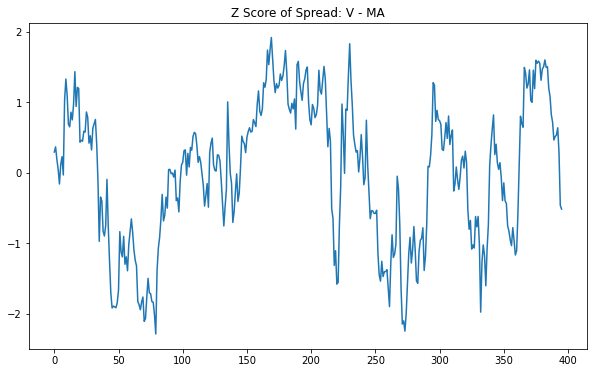

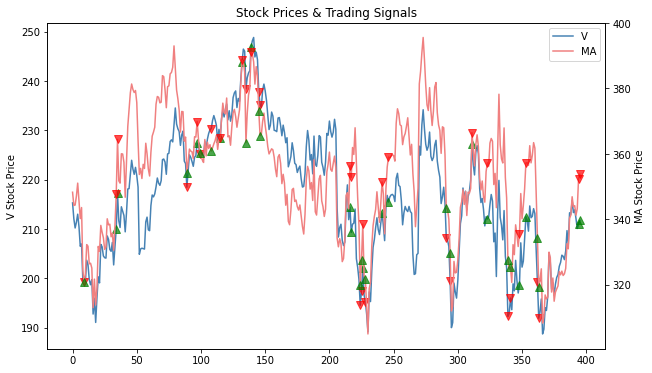

In [9]:
GenerateTradingPositions(prices, tickers)
PlotGraphs_withTradingSignals(prices, tickers)


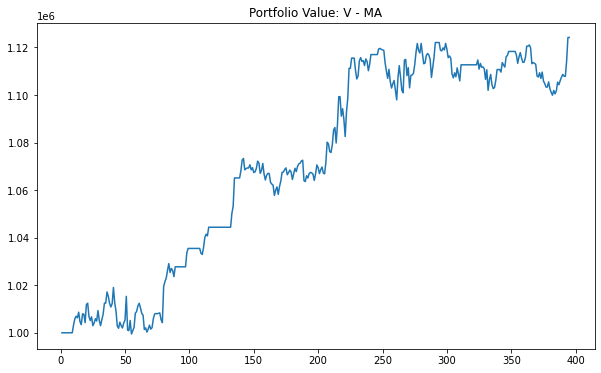

In [10]:
CalculateProfitandLoss(prices, tickers)